In [34]:
!pip install opencv-python

In [35]:
import cv2

def quick_resize(img, scale_percent):
    
    # scale_percent - percent of the original image's scale
    
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    return resized

def is_center_pixel_extremum(pixel_value, top_layer, curr_layer, next_layer):
    
    """
    Checks whether the point of interest / pixel is the extremum (local max or local min) within the provided region of interest
    
    args:
    pixel_value - value of the pixel in the point of interest
    top_layer, curr_layer, next_layer - region of interest (list)
    
    """
    
    # Concatenate individual regions
    region_of_interest = top_layer + curr_layer + next_layer

    # Flatten region of interest
    region_of_interest_flatten = [item for sublist in region_of_interest for item in sublist]

    # Check for extremum case
    is_extremum = any(pixel_value == [max(region_of_interest_flatten), min(region_of_interest_flatten)]) and (sum(pixel_value == region_of_interest_flatten) == 1)
    
    return is_extremum

In [36]:
import cv2
import numpy as np
from lib.helper_functions import quick_resize, is_center_pixel_extremum

def generate_image_pyramid(img, num_octaves = 4, num_intervals = 5, step_size = 1):
    
    """
    Generate image pyramid for SIFT.
    
    args:
    img - image object
    num_octaves = number of octave (scales)
    num_intervals - number of gaussian operator intervals
    step_size - size of each interval for gaussian operator
    
    out:
    img_pyramid - image pyramid list. each element corresponds to an octave (list), and each element of an octave corresponds to a laplacian image (gaussian blurred)
    """
    
    img_pyramid = []
    imgs_scaled = img

    for i in range(num_octaves):

        # Gaussian Operator parameter
        sigmas = np.arange(1, step_size * (num_intervals + 1), step_size)

        # Create a list of gaussian blurs using different values of sigma parameter
        gaussian_images = []
        for sigma in sigmas:
            gaussian_images.append(cv2.GaussianBlur(imgs_scaled, (0,0), sigma, cv2.BORDER_DEFAULT))

        # Append each list of gaussian images to the main img_pyramid list
        img_pyramid.append(gaussian_images)

        # Scale down image by half the original size
        imgs_scaled = quick_resize(imgs_scaled, 50)
        
    return img_pyramid

def calculate_dog(img_pyramid, num_octaves = 4):
    
    DoG = []
    num_intervals = len(img_pyramid[0])
    num_octaves = len(img_pyramid)

    for i in range(num_octaves):

        DoG_row = []
        for j in range(num_intervals - 1):

            # Subtract images of adjacent intervals within the same octave
            DoG_row.append(img_pyramid[i][j+1] - img_pyramid[i][j])

        DoG.append(DoG_row)
        
    return DoG

def get_region_of_interest(octave, DoG_image_index, pixel_coordinates, PRINT_INFO = False):
    
    """
    Gets the region if interest surrounding a point in a 3x3x3 cube, if any.
    
    Args:
        octave - list of DoG images. Each element from this list must be a 2D image of the same dimensions
        DoG_image_index - index to identify current octave
        pixel_coordinate - coordinate of the current pixel being considered
        
    Out:
        prev_octave - region from the prev octave (top of the stack)
        curr_octave - region of the current octave
        next_octave - region of the next octave (bottom of the stack)
    """
    
    pixel_row_index, pixel_col_index = pixel_coordinates

    # Calculate upper and lower bounds (for cases where the point of interest is at the edge or corner of the 3x3x3 cube)
    row_lower_bound = max(0,pixel_row_index - 1)
    row_upper_bound = pixel_row_index + 2
    col_lower_bound = max(0,pixel_col_index - 1)
    col_upper_bound = pixel_col_index + 2

    # If current octave is the top-most of the octave stack
    if DoG_image_index == 0:
        prev_octave = np.array([])
    else:
        prev_octave = octave[DoG_image_index - 1][row_lower_bound : row_upper_bound, col_lower_bound : col_upper_bound]

    # If the current octave is at bottom-most of the octave stack
    if DoG_image_index == len(octave) - 1:
        next_octave = np.array([])
    else:
        next_octave = octave[DoG_image_index + 1][row_lower_bound : row_upper_bound, col_lower_bound : col_upper_bound]

    curr_octave = octave[DoG_image_index][row_lower_bound : row_upper_bound, col_lower_bound : col_upper_bound]

    if PRINT_INFO:
        print(f'Previous Octave:\n {prev_octave}\n')
        print(f'Current Octave:\n {curr_octave}\n')
        print(f'Next Octave:\n {next_octave}')
        
    return prev_octave.tolist(), curr_octave.tolist(), next_octave.tolist()

def SIFT_feature_detection(DoG, ref_image, block_size = 2, ksize = 3, k = 0.03, threshold_parameter = 0.001):

    """
    
    args:
    block_size - Neighborhood size for corner detection
    ksize - Aperture parameter for Sobel operator
    k - Harris corner detection free parameter
    
    # Threshold for classifying keypoints as edges or flats
    
    out:
    keypoints - list of keypoints generated via the SIFT algorithm 
              - format: [octave_index, DoG_image_index, (pixel_row_index, pixel_col_index)]
    
    """

    keypoints = []
    
    # Calculate corner coefficient to filter out flats and edges
    # NOTE: not sure whether or not to manually calculate the hessian matrix or to use this library for this purpose
    corners = cv2.cornerHarris(ref_image, block_size, ksize, k)

    # Define threshold
    threshold = threshold_parameter * corners.max()
    
    # iterate across octaves in our DoG list
    for octave_index, octave in enumerate(DoG):

        # iterate across DoG images (2d array) in an octave (list)
        for DoG_image_index, DoG_image in enumerate(octave):

            # iterate across image rows (1d array) in a DoG image (2d array)
            for pixel_row_index, image_row in enumerate(DoG_image):

                # iterate across columns in an image rows
                for pixel_col_index, center_pixel_value in enumerate(image_row):

                    # get coordinate of point of interest
                    center_pixel_coordinate = (pixel_row_index, pixel_col_index)

                    # get region of interest
                    prev_octave, curr_octave, next_octave = get_region_of_interest(octave, DoG_image_index, center_pixel_coordinate, PRINT_INFO = False)

                    # check if point of interest is the extremum of the region of interest 
                    if is_center_pixel_extremum(center_pixel_value, prev_octave, curr_octave, next_octave):

                        # scale pixel coordinates back to the size of the original image
                        scaled_pixel_row_index = pixel_row_index*(2**octave_index)
                        scaled_pixel_col_index = pixel_col_index*(2**octave_index)

                        # Accept only if extremum detected is NOT an flat or edge
                        if corners[scaled_pixel_row_index, scaled_pixel_col_index] > threshold:

                            # append to keypoint output list
                            keypoints.append([octave_index, DoG_image_index, (pixel_row_index, pixel_col_index)])
                            
    return keypoints

In [37]:
import cv2
import matplotlib.pyplot as plt

from lib.sift_functions import generate_image_pyramid, calculate_dog, get_region_of_interest, SIFT_feature_detection
from lib.helper_functions import quick_resize, is_center_pixel_extremum

In [38]:
# Apply the modules created in PART 1 - keypoint detection
img = cv2.imread('/Users/subhashmishra/Downloads/LLL1.jpeg')

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_pyramid = generate_image_pyramid(img_gray)

DoG = calculate_dog(img_pyramid)

keypoints = SIFT_feature_detection(DoG, img_gray)

Text(0.5, 1.0, 'SIFT Module Feature Detection Output (for Comparison)')

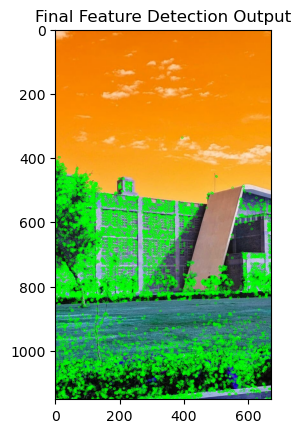

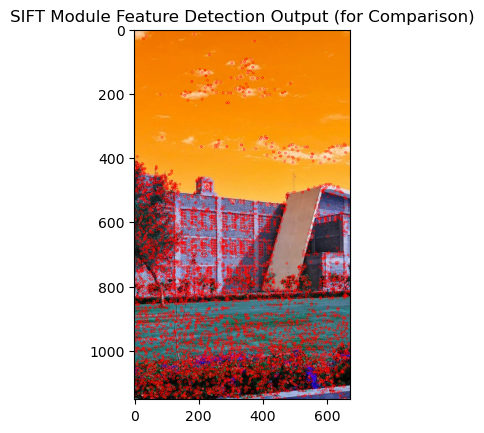

In [39]:
plt.figure()
keypoint_objects = [cv2.KeyPoint(kp_y * 2**octave_index, kp_x * 2**octave_index, 1) for octave_index, _, (kp_x, kp_y) in keypoints]
plt.imshow(cv2.drawKeypoints(img, keypoint_objects,  None, (0, 255, 0)))
plt.title('Final Feature Detection Output')

plt.figure()
sift = cv2.SIFT_create()
kp_ = sift.detect(img_gray,None)
plt.imshow(cv2.drawKeypoints(img, kp_,  None, (255, 0, 0)))
plt.title('SIFT Module Feature Detection Output (for Comparison)')